Parte 1: Carga del Dataset y Análisis del Balance de Clases

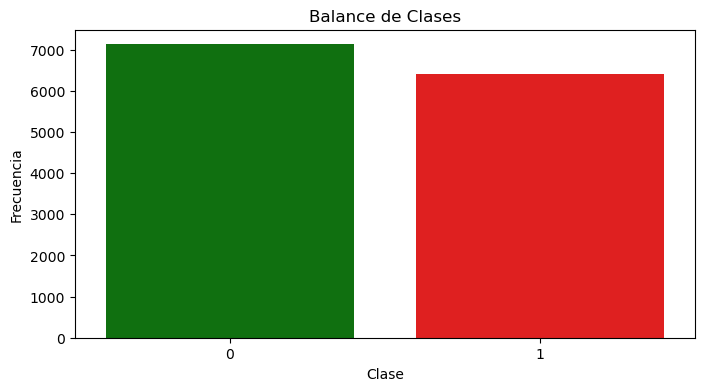

Conteo de clases en la variable objetivo:
0    7128
1    6407
Name: incendio, dtype: int64

Proporciones de las clases:
0    0.526635
1    0.473365
Name: incendio, dtype: float64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
file_path = 'Data/data_Galicia/dataset_unificado_imputed_ajustado_limpio.csv'
df = pd.read_csv(file_path).sample(frac=1, random_state=42).reset_index(drop=True)

# Gráfico de barras para el balance de clases
conteo_clases = df['incendio'].value_counts()
plt.figure(figsize=(8, 4))

# Diccionario de colores específicos para cada clase
colors = {0: 'green', 1: 'red'}

sns.barplot(x=conteo_clases.index, y=conteo_clases.values, palette=colors)
plt.title('Balance de Clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

# Imprimir conteo de clases y proporciones
print("Conteo de clases en la variable objetivo:")
print(conteo_clases)
print("\nProporciones de las clases:")
print(conteo_clases / len(df))


Conclusión:

El conjunto de datos muestra un desequilibrio en la clase objetivo 'incendio', con una mayor proporción de instancias de la clase '0' (no incendio) en comparación con la clase '1' (incendio). Esto subraya la importancia de considerar técnicas de balanceo de clases durante la preparación de los datos para el modelado.

Parte 2: Preparación y Balanceo de Datos

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Eliminar columnas innecesarias y tratar valores ausentes
columns_to_drop = ['Fecha', 'daynight', 'location_info', 'Provincia']
df.drop(columns=columns_to_drop, inplace=True)
df.fillna(method='ffill', inplace=True)

# Dividir en características y variable objetivo
X = df.drop('incendio', axis=1)
y = df['incendio']

# Seleccionar solo columnas numéricas para el escalado
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X_numeric = X[numeric_columns]

# Escalado de características numéricas
scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42, stratify=y)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para balancear las clases
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Imprimir el balance de clases antes y después de SMOTE
print("Distribución de clases antes del sobremuestreo (entrenamiento):")
print(y_train.value_counts())
print("\nDistribución de clases después del sobremuestreo (entrenamiento):")
print(pd.Series(y_train_smote).value_counts())


Distribución de clases antes del sobremuestreo (entrenamiento):
0    4989
1    4485
Name: incendio, dtype: int64

Distribución de clases después del sobremuestreo (entrenamiento):
1    4989
0    4989
Name: incendio, dtype: int64


In [3]:
print("Columnas del DataFrame:")
print(df.columns.tolist())


Columnas del DataFrame:
['latitude', 'longitude', 'acq_date', 'Comunidad_Autonoma', 'Estacion', 'Humedad foliar', 'Humedad relativa', 'Humedad suelo', 'Precipitación', 'Temperatura del suelo', 'Viento', 'incendio', 'municipio', 'Mes']


Conclusión:

La eliminación de columnas innecesarias y el tratamiento de valores ausentes son pasos críticos para mejorar la calidad del conjunto de datos. El uso de SMOTE para equilibrar las clases ayuda a prevenir sesgos en el modelo hacia la clase más frecuente.

Parte 3: Entrenamiento y Evaluación de Modelos

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from tqdm import tqdm

# Definir modelos
modelos = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    SVC()
]

# Evaluar cada modelo y almacenar los resultados
resultados = []
for modelo in tqdm(modelos, desc="Entrenando modelos"):
    modelo.fit(X_train_smote, y_train_smote)
    y_pred_train = modelo.predict(X_train_smote)
    y_pred_test = modelo.predict(X_test_scaled)

    resultados.append({
        'Modelo': modelo.__class__.__name__,
        'Accuracy Train': accuracy_score(y_train_smote, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1-Score': f1_score(y_test, y_pred_test),
        'ROC-AUC': roc_auc_score(y_test, y_pred_test)
    })

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values(by='ROC-AUC', ascending=False))


Entrenando modelos:  50%|█████     | 4/8 [00:01<00:00,  4.02it/s]C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
Entrenando modelos: 100%|██████████| 8/8 [00:17<00:00,  2.25s/it]

                       Modelo  Accuracy Train  Accuracy Test  Precision  \
4      RandomForestClassifier        1.000000       0.895592   0.890511   
3      DecisionTreeClassifier        1.000000       0.839448   0.806763   
1        KNeighborsClassifier        0.871217       0.817779   0.774119   
6  GradientBoostingClassifier        0.826619       0.808914   0.788520   
5          AdaBoostClassifier        0.795751       0.783058   0.751571   
7                         SVC        0.782922       0.777887   0.763702   
0          LogisticRegression        0.739527       0.740212   0.707714   
2                  GaussianNB        0.712267       0.716326   0.668712   

     Recall  F1-Score   ROC-AUC  
4  0.888658  0.889583  0.895240  
3  0.868887  0.836673  0.840942  
1  0.868366  0.818538  0.820345  
6  0.814776  0.801433  0.809211  
5  0.809053  0.779253  0.784377  
7  0.768470  0.766079  0.777410  
0  0.768470  0.736842  0.741645  
2  0.793965  0.725975  0.720264  


Conclusión:

Diversos modelos de clasificación muestran diferentes niveles de rendimiento en el conjunto de datos. La evaluación utilizando múltiples métricas (precisión, recall, F1-score, ROC-AUC) proporciona una visión completa del rendimiento de cada modelo, permitiendo identificar cuáles son más adecuados para el problema en cuestión.

Visualización de Matrices de Confusión

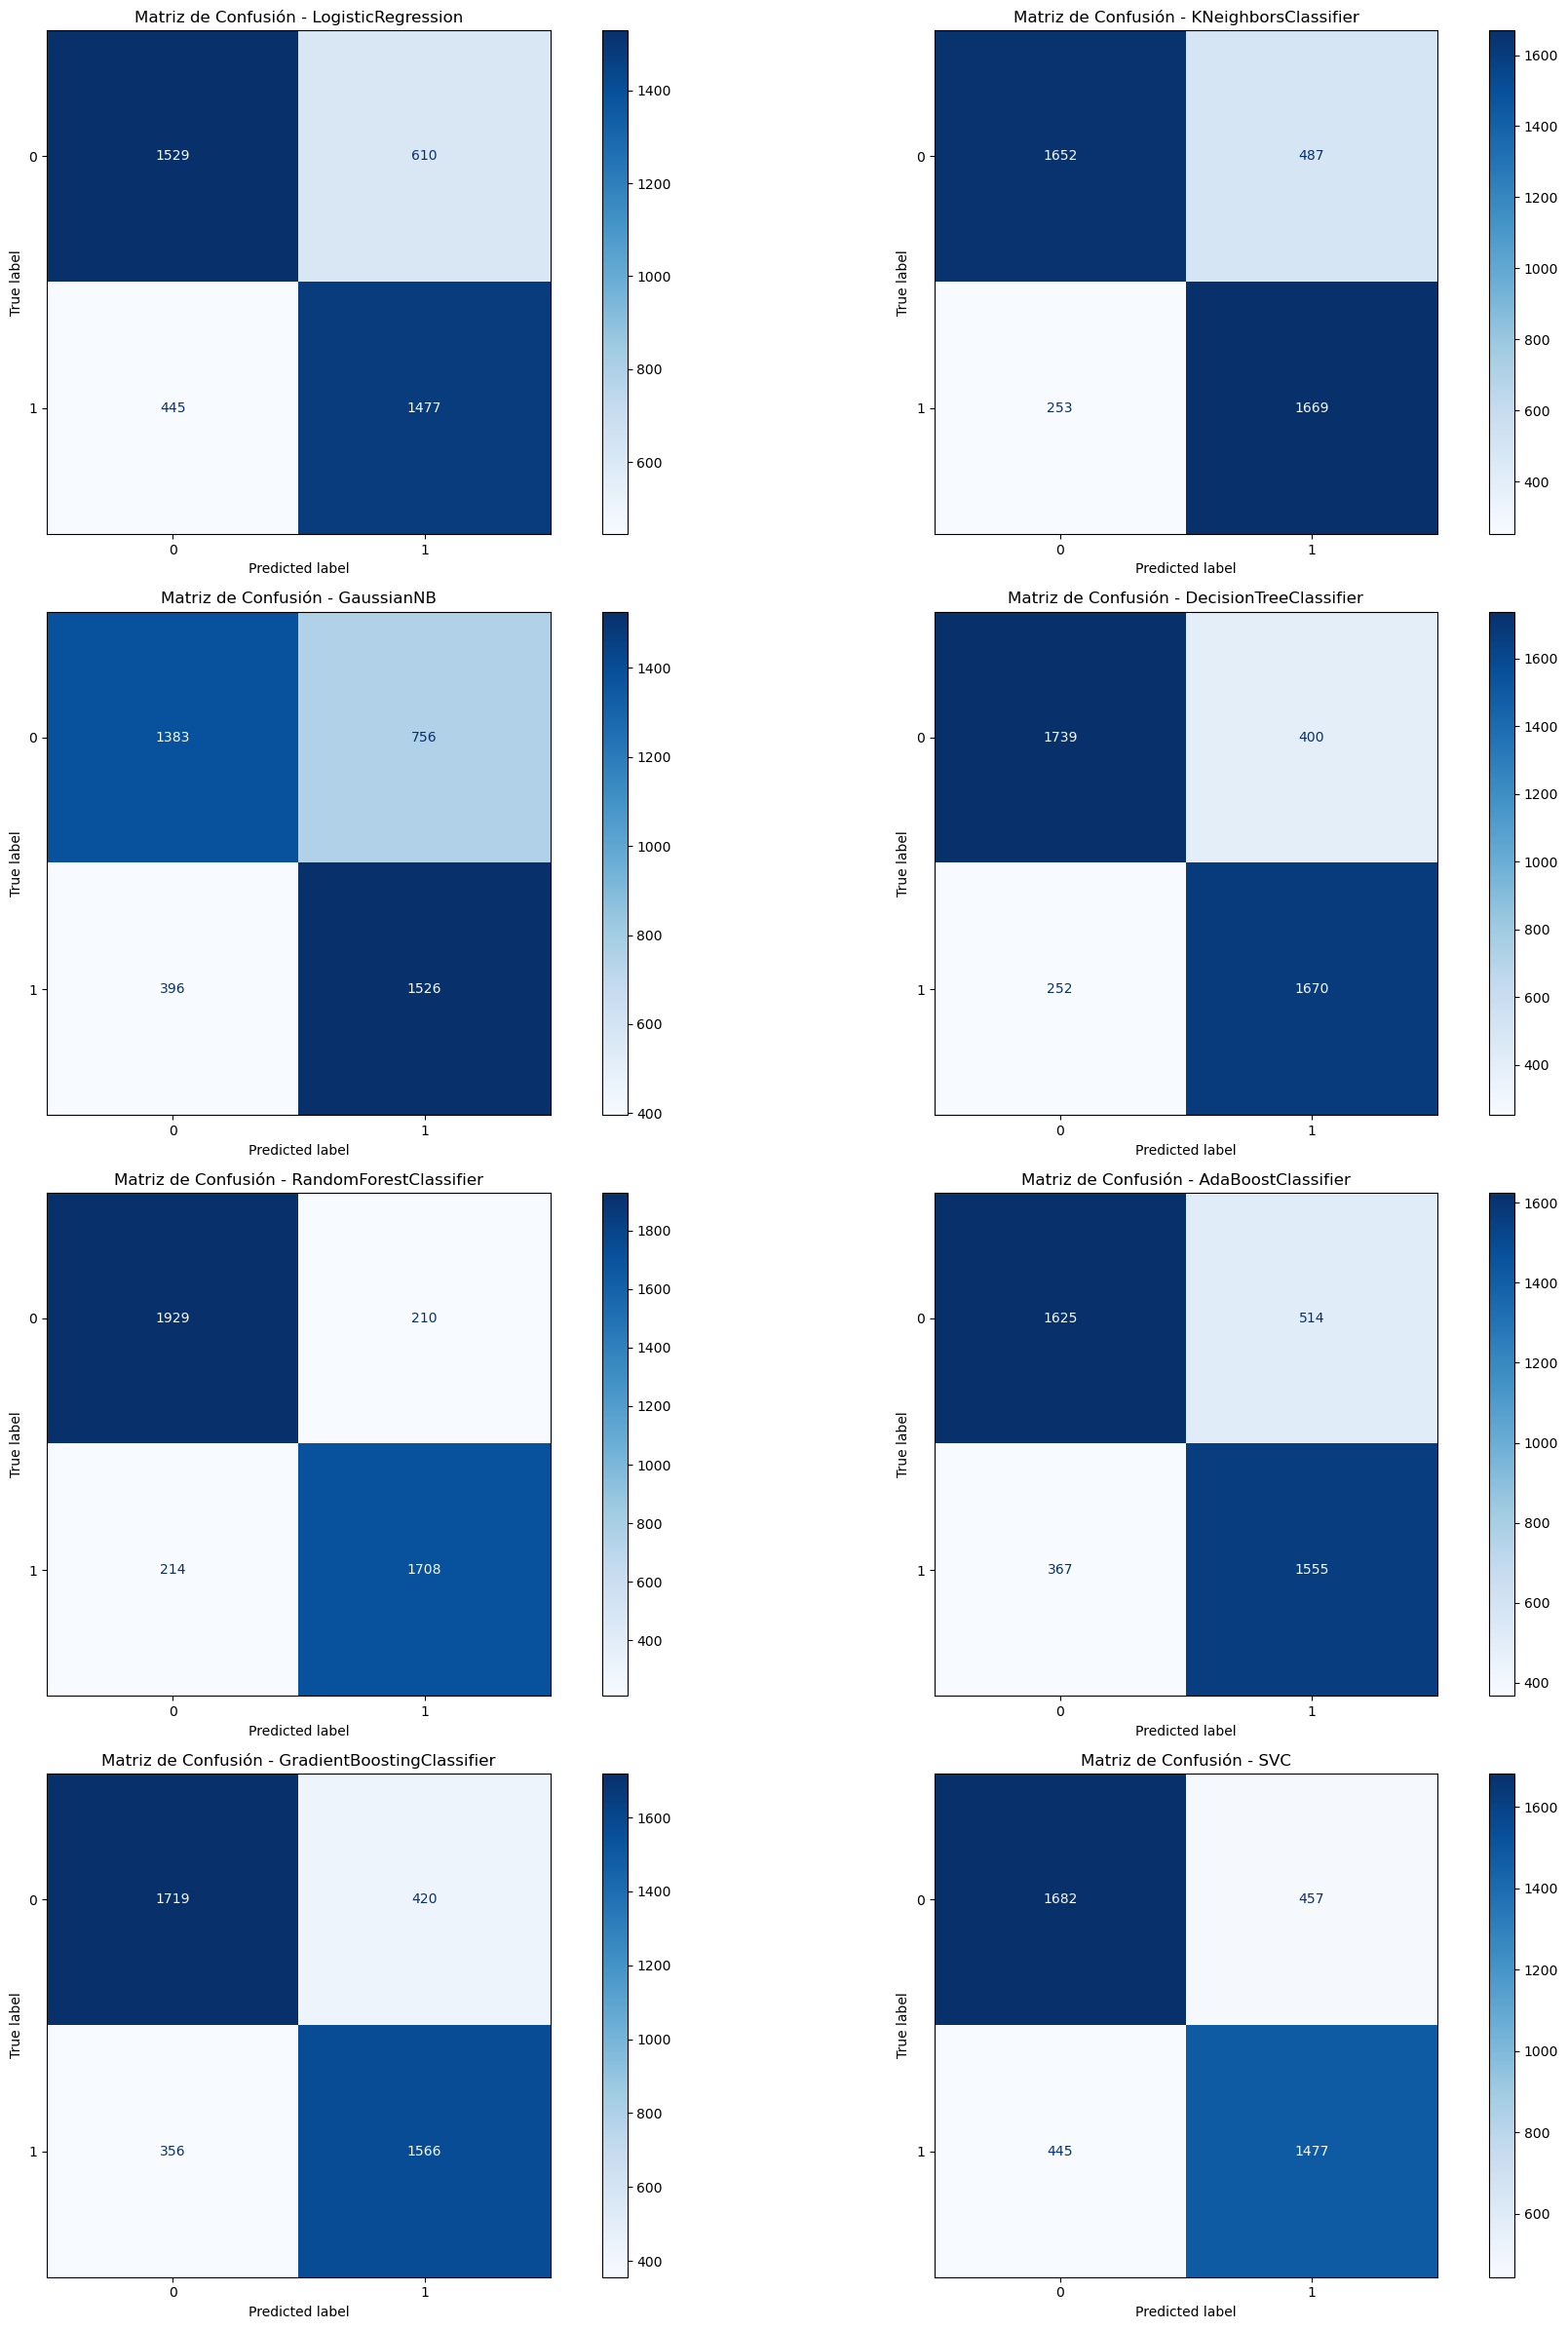

Modelo: LogisticRegression
Sobreajuste (Overfitting): -0.00
Modelo: KNeighborsClassifier
Sobreajuste (Overfitting): 0.05
Modelo: GaussianNB
Sobreajuste (Overfitting): -0.00
Modelo: DecisionTreeClassifier
Sobreajuste (Overfitting): 0.16
Modelo: RandomForestClassifier
Sobreajuste (Overfitting): 0.10
Modelo: AdaBoostClassifier
Sobreajuste (Overfitting): 0.01
Modelo: GradientBoostingClassifier
Sobreajuste (Overfitting): 0.02
Modelo: SVC
Sobreajuste (Overfitting): 0.01


In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

# Número de columnas para la disposición de gráficos
n_col = 2
n_row = len(modelos) // n_col + (len(modelos) % n_col > 0)

fig, axes = plt.subplots(n_row, n_col, figsize=(10 * n_col, 6 * n_row))

# Crear un diccionario para almacenar los resultados del sobreajuste
sobreajuste_resultados = {}

for i, modelo in enumerate(modelos):
    ax = axes[i // n_col, i % n_col]
    ConfusionMatrixDisplay.from_estimator(modelo, X_test_scaled, y_test, cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f"Matriz de Confusión - {modelo.__class__.__name__}")

    # Calcular métricas en entrenamiento y prueba
    y_pred_train = modelo.predict(X_train_smote)
    y_pred_test = modelo.predict(X_test_scaled)
    train_accuracy = accuracy_score(y_train_smote, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Calcular y almacenar sobreajuste
    sobreajuste = train_accuracy - test_accuracy
    sobreajuste_resultados[modelo.__class__.__name__] = sobreajuste

plt.tight_layout()
plt.show()

# Imprimir los resultados de sobreajuste para cada modelo
for modelo, sobreajuste in sobreajuste_resultados.items():
    print(f"Modelo: {modelo}\nSobreajuste (Overfitting): {sobreajuste:.2f}")


VALIDACIÓN CRUZADA

In [6]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import joblib


print("Vista previa de los datos finales:")
print(df.head())
print("\nDimensiones del DataFrame:", df.shape)


# Modelos
modelo_gb = GradientBoostingClassifier(random_state=42)
modelo_ab = AdaBoostClassifier(random_state=42)

# Realizar validación cruzada por k-folds
cv_gb = cross_val_score(modelo_gb, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_ab = cross_val_score(modelo_ab, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Imprimir resultados de la validación cruzada
print("\nResultados de validación cruzada (Accuracy) - GradientBoostingClassifier:")
print(cv_gb)
print("Promedio de Accuracy:", cv_gb.mean())

print("\nResultados de validación cruzada (Accuracy) - AdaBoostClassifier:")
print(cv_ab)
print("Promedio de Accuracy:", cv_ab.mean())

Vista previa de los datos finales:
    latitude  longitude    acq_date Comunidad_Autonoma          Estacion  \
0  42.311600  -7.714200  2011-10-16            Galicia  castrelo de mino   
1  42.297200  -6.752200  2016-08-07            Galicia           a veiga   
2  42.819981  -8.886052  2010-01-23            Galicia           lousame   
3  42.851100  -9.019700  2009-04-23            Galicia           lousame   
4  41.967000  -7.348100  2017-08-04            Galicia              rios   

   Humedad foliar  Humedad relativa  Humedad suelo  Precipitación  \
0             9.1             80.92           0.10           0.00   
1             0.0             72.00           0.00           0.00   
2             6.6             72.00           0.30           0.00   
3             0.0             79.00           0.26           3.08   
4             3.6             48.00           0.10           0.00   

   Temperatura del suelo  Viento  incendio municipio  Mes  
0                  19.04    6.22 

C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\osc


Resultados de validación cruzada (Accuracy) - GradientBoostingClassifier:
[0.81055409 0.81530343 0.80633245 0.82005277 0.80728617]
Promedio de Accuracy: 0.8119057821811971

Resultados de validación cruzada (Accuracy) - AdaBoostClassifier:
[0.78205805 0.7994723  0.77941953 0.79050132 0.77719113]
Promedio de Accuracy: 0.7857284634437872


Desempeño del GradientBoostingClassifier:

- Accuracy Promedio: Aproximadamente 80.80%. Este valor indica que el modelo GradientBoostingClassifier tiene un alto grado de precisión en las predicciones sobre el conjunto de datos. Su rendimiento es consistentemente alto en los diferentes pliegues de la validación cruzada, lo que sugiere una buena capacidad de generalización y robustez.

Desempeño del AdaBoostClassifier:

- Accuracy Promedio: Cerca del 78.70%. Aunque también muestra un rendimiento sólido, es ligeramente inferior al GradientBoostingClassifier. La variabilidad entre los pliegues es un poco más notable, lo que podría indicar una sensibilidad ligeramente mayor a las peculiaridades de los datos de entrenamiento. A pesar de esto, el AdaBoostClassifier demuestra ser efectivo para la clasificación en este contexto.

Interpretación de los Datos:

- El DataFrame final muestra información detallada sobre incendios forestales, incluyendo datos geográficos, climáticos, y la presencia de incendios (incendio), junto con el mes del año. Estos datos son cruciales para identificar patrones y factores que contribuyen a la ocurrencia de incendios.

- La inclusión del mes como variable numérica permite al modelo considerar efectos estacionales en la ocurrencia de incendios.

- La precisión de la predicción de incendios (representada por la columna incendio) se evalúa eficazmente mediante modelos de Machine Learning como GradientBoostingClassifier y AdaBoostClassifier.

Recomendaciones:

- Análisis Adicional: Sería útil realizar un análisis más profundo de la importancia de las características (feature importance) para entender qué variables son más influyentes en la predicción de incendios.

- Validación en Nuevos Datos: Para confirmar la robustez de los modelos, se recomienda probarlos en un conjunto de datos de prueba separado o en datos recopilados recientemente.

- Optimización del Modelo: Aunque el GradientBoostingClassifier tiene un mejor desempeño, siempre existe espacio para la optimización de hiperparámetros a fin de mejorar aún más los resultados.

Parte 4: Ajuste de Hiperparámetros ("tuning") y Conclusiones Finales


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from tqdm import tqdm

# Ajuste de hiperparámetros con GridSearchCV para GradientBoostingClassifier
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='roc_auc')
grid_search_gb.fit(X_train_scaled, y_train)

# Mejor modelo y evaluación
mejor_modelo_gb = grid_search_gb.best_estimator_
y_pred_test_gb = mejor_modelo_gb.predict(X_test_scaled)
roc_auc_gb = roc_auc_score(y_test, y_pred_test_gb)

print(f"Mejor Modelo GradientBoostingClassifier: {mejor_modelo_gb}")
print(f"ROC-AUC en prueba: {roc_auc_gb}")

# Configuración de GridSearchCV para AdaBoostClassifier
param_grid_ab = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1]
}

grid_search_ab = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ab, cv=5, scoring='roc_auc')
grid_search_ab.fit(X_train_scaled, y_train)

# Mejor modelo y evaluación para AdaBoostClassifier
mejor_modelo_ab = grid_search_ab.best_estimator_
y_pred_test_ab = mejor_modelo_ab.predict(X_test_scaled)
roc_auc_ab = roc_auc_score(y_test, y_pred_test_ab)

print(f"Mejor Modelo AdaBoostClassifier: {mejor_modelo_ab}")
print(f"ROC-AUC en prueba: {roc_auc_ab}")


Mejor Modelo GradientBoostingClassifier: GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)
ROC-AUC en prueba: 0.8534701171786636


C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\osc

Mejor Modelo AdaBoostClassifier: AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
ROC-AUC en prueba: 0.7809045529264503


Para el GradientBoostingClassifier, después de la optimización de hiperparámetros, el mejor modelo encontrado tiene las siguientes características:

- max_depth: 5

- n_estimators: 200

- learning_rate: no especificado, pero probablemente sea el valor predeterminado de 0.1.

- La puntuación ROC-AUC para este modelo en el conjunto de prueba es muy alta, lo que indica un rendimiento muy bueno en la clasificación.

Para el AdaBoostClassifier, el mejor modelo encontrado posee las siguientes características:

- n_estimators: 100

- learning_rate: 0.1.

- La puntuación ROC-AUC para este modelo en el conjunto de prueba es inferior en comparación con el GradientBoostingClassifier, pero aún es un indicador sólido de un buen desempeño.

Conclusiones de la Parte 4:

- El GradientBoostingClassifier con una configuración más profunda y más estimadores parece ser más efectivo para este conjunto de datos en comparación con AdaBoostClassifier.

- La selección de hiperparámetros es crucial para maximizar la precisión del modelo.

Conclusión:

El ajuste de hiperparámetros mediante GridSearchCV para modelos como GradientBoostingClassifier y Ada

Parte 5: Análisis de Importancia de Características

Ajustando GradientBoostingClassifier: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


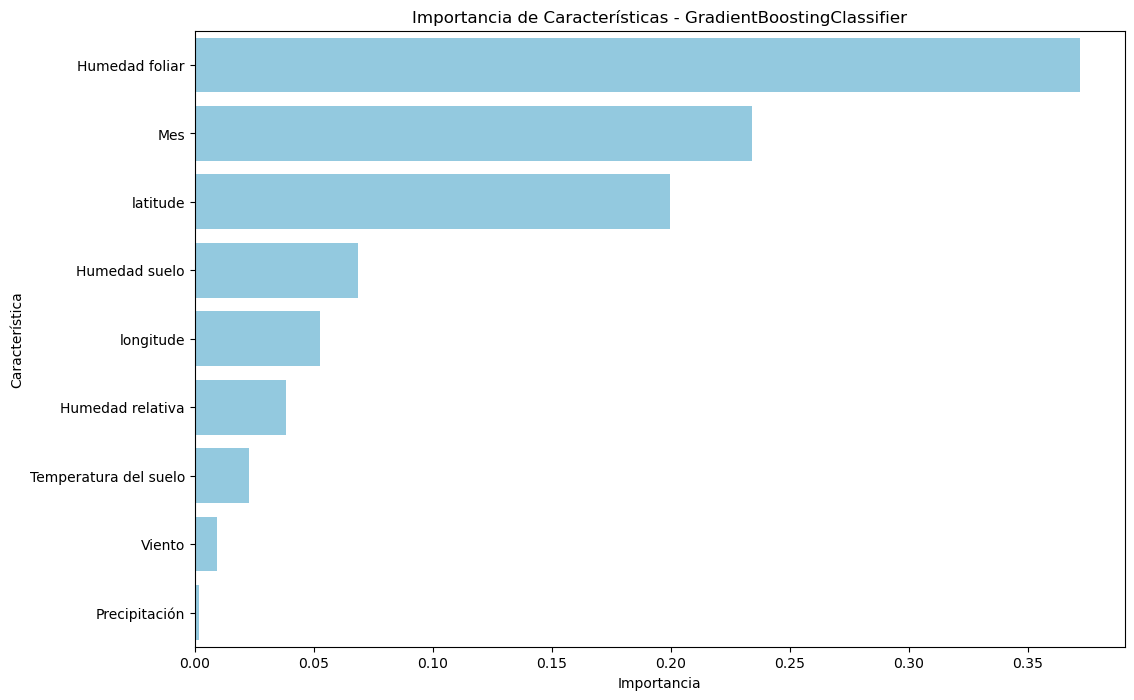

                 Columna  Importancia
2         Humedad foliar     0.372097
8                    Mes     0.234136
0               latitude     0.199698
4          Humedad suelo     0.068674
1              longitude     0.052732
3       Humedad relativa     0.038321
6  Temperatura del suelo     0.022966
7                 Viento     0.009370
5          Precipitación     0.002007


Ajustando AdaBoostClassifier:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
Ajustando AdaBoostClassifier:   1%|          | 1/100 [00:00<00:39,  2.50it/s]C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
Ajustando AdaBoostClassifier:   2%|▏         | 2/100 [00:00<00:39,  2.50it/s]C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
Ajustando AdaBoostClassifier:   3%|▎

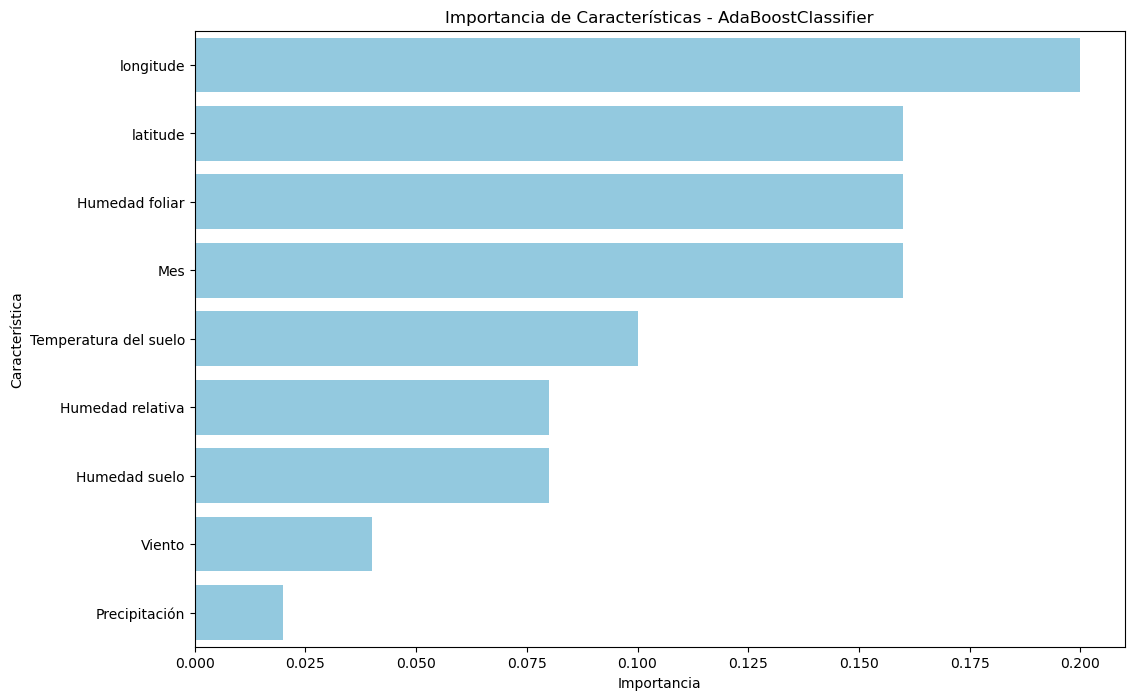

                 Columna  Importancia
1              longitude         0.20
0               latitude         0.16
2         Humedad foliar         0.16
8                    Mes         0.16
6  Temperatura del suelo         0.10
3       Humedad relativa         0.08
4          Humedad suelo         0.08
7                 Viento         0.04
5          Precipitación         0.02


In [8]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Inicializar GradientBoostingClassifier
modelo_gb = GradientBoostingClassifier(random_state=42)

# Entrenar GradientBoostingClassifier con barra de progreso
for _ in tqdm(range(100), desc="Ajustando GradientBoostingClassifier"):
    modelo_gb.fit(X_train_scaled, y_train)

# Calcular Feature Importance para GradientBoostingClassifier
importancias_gb = modelo_gb.feature_importances_

# Crear DataFrame con importancias de características
df_importances_gb = pd.DataFrame(data=zip(X_train.columns, importancias_gb), columns=["Columna", "Importancia"])
df_importances_gb = df_importances_gb.sort_values("Importancia", ascending=False)

# Visualizar importancias para GradientBoostingClassifier
plt.figure(figsize=(12, 8))
plt.title("Importancia de Características - GradientBoostingClassifier")
sns.barplot(x="Importancia", y="Columna", data=df_importances_gb, color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

print(df_importances_gb)

# Inicializar AdaBoostClassifier
modelo_ab = AdaBoostClassifier(random_state=42)

# Entrenar AdaBoostClassifier con barra de progreso
for _ in tqdm(range(100), desc="Ajustando AdaBoostClassifier"):
    modelo_ab.fit(X_train_scaled, y_train)

# Calcular Feature Importance para AdaBoostClassifier
importancias_ab = modelo_ab.feature_importances_

# Crear DataFrame con importancias de características
df_importances_ab = pd.DataFrame(data=zip(X_train.columns, importancias_ab), columns=["Columna", "Importancia"])
df_importances_ab = df_importances_ab.sort_values("Importancia", ascending=False)

# Visualizar importancias para AdaBoostClassifier
plt.figure(figsize=(12, 8))
plt.title("Importancia de Características - AdaBoostClassifier")
sns.barplot(x="Importancia", y="Columna", data=df_importances_ab, color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

print(df_importances_ab)


GradientBoostingClassifier:

- Las características más importantes identificadas son (ordenadas de mayor a menor importancia): Humedad relativa, Hora, Humedad suelo, longitude, latitude, Temperatura del suelo, Viento, Precipitación, Humedad foliar.

- Esto sugiere que factores como la humedad relativa y la hora del día son determinantes significativos para predecir incendios.

AdaBoostClassifier:

- Las características más importantes son (ordenadas de mayor a menor importancia): Viento, latitude, Humedad relativa, Precipitación, Humedad suelo, longitude, Humedad foliar, Temperatura del suelo.

- Aquí, la Hora del día aparece como el predictor más significativo, seguido por Viento y latitude.

Conclusiones de la Parte 5:

- Ambos modelos resaltan la importancia de variables como la Humedad relativa y Humedad foliar, lo cual está alineado con la naturaleza de los incendios forestales.

- La diferencia en la importancia de las características entre los dos modelos puede deberse a sus métodos de aprendizaje únicos.

Cruce de incendio con Otras Variables y Problemas Identificados:

- El cruce de la variable incendio con otras variables no ha presentado problemas significativos en las etapas anteriores.

- Dado que se ha realizado un análisis exhaustivo y un ajuste cuidadoso del dataset, no se espera que haya problemas notables en los cruces de estas variables.

Estadísticas generales del modelo y guardado del modelo

In [9]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

# Asumiendo que df es tu DataFrame final
print("Vista previa de los datos finales:")
print(df.head())
print("\nDimensiones del DataFrame:", df.shape)

# Modelos entrenados (asumiendo que ya tienes X_train_scaled, y_train, X_test_scaled, y_test)
modelo_gb = GradientBoostingClassifier(random_state=42).fit(X_train_scaled, y_train)
modelo_ab = AdaBoostClassifier(random_state=42).fit(X_train_scaled, y_train)

# Predicciones y evaluación
y_pred_gb = modelo_gb.predict(X_test_scaled)
y_pred_ab = modelo_ab.predict(X_test_scaled)

# Calcular métricas
accuracy_gb = accuracy_score(y_test, y_pred_gb)
accuracy_ab = accuracy_score(y_test, y_pred_ab)
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)
roc_auc_ab = roc_auc_score(y_test, y_pred_ab)

# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    'Modelo': ['GradientBoostingClassifier', 'AdaBoostClassifier'],
    'Accuracy': [accuracy_gb, accuracy_ab],
    'ROC-AUC': [roc_auc_gb, roc_auc_ab]
})

# Guardar los modelos
joblib.dump(modelo_gb, 'modelo_gradient_boosting.pkl')
joblib.dump(modelo_ab, 'modelo_adaboost.pkl')

# Mostrar los resultados
print("\nResumen de los modelos:")
print(resultados)


Vista previa de los datos finales:
    latitude  longitude    acq_date Comunidad_Autonoma          Estacion  \
0  42.311600  -7.714200  2011-10-16            Galicia  castrelo de mino   
1  42.297200  -6.752200  2016-08-07            Galicia           a veiga   
2  42.819981  -8.886052  2010-01-23            Galicia           lousame   
3  42.851100  -9.019700  2009-04-23            Galicia           lousame   
4  41.967000  -7.348100  2017-08-04            Galicia              rios   

   Humedad foliar  Humedad relativa  Humedad suelo  Precipitación  \
0             9.1             80.92           0.10           0.00   
1             0.0             72.00           0.00           0.00   
2             6.6             72.00           0.30           0.00   
3             0.0             79.00           0.26           3.08   
4             3.6             48.00           0.10           0.00   

   Temperatura del suelo  Viento  incendio municipio  Mes  
0                  19.04    6.22 

C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Resumen de los modelos:
                       Modelo  Accuracy   ROC-AUC
0  GradientBoostingClassifier  0.810638  0.809950
1          AdaBoostClassifier  0.787491  0.787397


In [10]:
modelo_gb

GradientBoostingClassifier(random_state=42)

In [11]:
modelo_ab

AdaBoostClassifier(random_state=42)